# SuperVoice dVAE evaluation
This notebook provides tools for dVAE evaluation

In [1]:
# Base
import itertools
from glob import glob
from tqdm import tqdm
from IPython.display import Audio, display
import fsspec
import os

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Local
from vocoder.model import Generator
from dvae.model import DiscreteVAE
from utils.misc import plot_specgram, plot_waveform
from utils.audio import spectogram, load_mono_audio
from train_config import config

### Environment

In [2]:
# Parameters
device = torch.device('cuda:0')
checkpoint = "./checkpoints/dvae_dvae_3gelu_160.pt"
checkpoint_vocoder = "./checkpoints/vocoder_sr_24khz.pt"

# Device and Model
dvae = DiscreteVAE(
    # Base mel spec parameters
    positional_dims=1,
    channels=config.audio.num_mels,

    # Number of possible tokens
    num_tokens=config.dvae.tokens,

    # Architecture
    codebook_dim=config.dvae.codebook_dim,
    hidden_dim=config.dvae.hidden_dim,
    num_resnet_blocks=config.dvae.num_resnet_blocks,
    kernel_size=config.dvae.kernel_size,
    num_layers=config.dvae.num_layers,
    use_transposed_convs=False,
).to(device)
generator = Generator(config).to(device)

# Load checkpoint
data = torch.load(checkpoint)
dvae.load_state_dict(data['dvae'])
print(data['step'])
data = torch.load(checkpoint_vocoder)
generator.load_state_dict(data['generator'])

# Switch to eval
dvae.eval()
generator.eval()
generator.remove_weight_norm()

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


1020579
Removing weight norm...


# Evaluation

In [3]:
# Custom file
from ipywidgets import FileUpload
upload = FileUpload(multiple=False)
upload

FileUpload(value=(), description='Upload')

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/functional.py:650: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:863.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


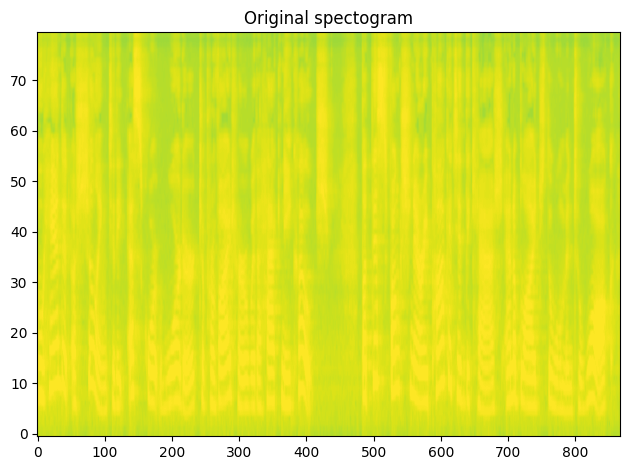

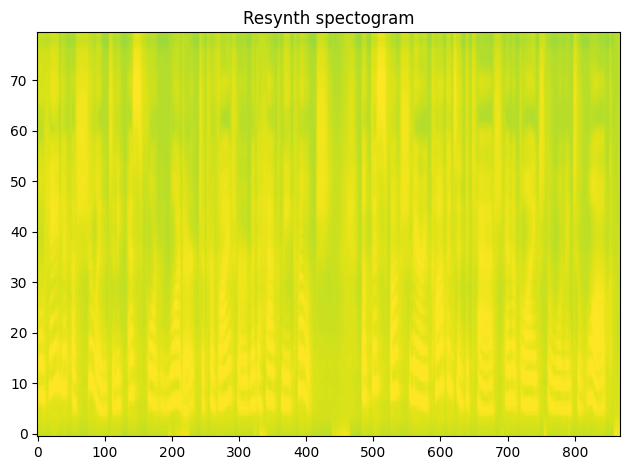

In [4]:
# Load
if len(upload.value) == 1:
    with open("eval_vocoder.out", "w+b") as i:
        i.write(upload.value[0].content)
    test = load_mono_audio("eval_vocoder.out", config.audio.sample_rate)
else:
    test = load_mono_audio("./external_datasets/lj-speech-1.1/wavs/LJ005-0006.wav", config.audio.sample_rate)
spec = spectogram(test, config.audio.n_fft, config.audio.num_mels, config.audio.hop_size, config.audio.win_size, config.audio.sample_rate)

# Generate
codes = dvae.get_codebook_indices(spec.unsqueeze(0).to(device) / config.dvae.log_mel_multiplier)
codes_spec, codes_spec_2 = dvae.infer(spec.unsqueeze(0).to(device) / config.dvae.log_mel_multiplier)
codes_spec = codes_spec * config.dvae.log_mel_multiplier
resynth = generator(codes_spec).detach().cpu().squeeze(0)
codes_spec = codes_spec.detach().cpu().squeeze(0)
resynth2 = generator(spec.unsqueeze(0).to(device)).detach().cpu().squeeze(0)
# resynth_spec = spectogram(resynth, config.audio.n_fft, config.audio.num_mels, config.audio.hop_size, config.audio.win_size, config.audio.sample_rate).squeeze(0)

# Source
plot_specgram(spec, title="Original spectogram")
plot_specgram(codes_spec.cpu(), title="Resynth spectogram")
# plot_waveform(test.unsqueeze(0),xlim=(0,len(test) / config.audio.sample_rate))
# plot_waveform(resynth,xlim=(0,len(test) / config.audio.sample_rate))
display(Audio(data=test, rate=config.audio.sample_rate))
display(Audio(data=resynth, rate=config.audio.sample_rate))
display(Audio(data=resynth2, rate=config.audio.sample_rate))

# Manual Synthesizing
This section allows you to use tokens that want to decode the sound

304 178 635 420 628 31 249 33 348 183 434 24 31 208 565 480 105 83 30 165 61 110 312 394 1 308 308 481 517 261 517
31 1.3226666666666667


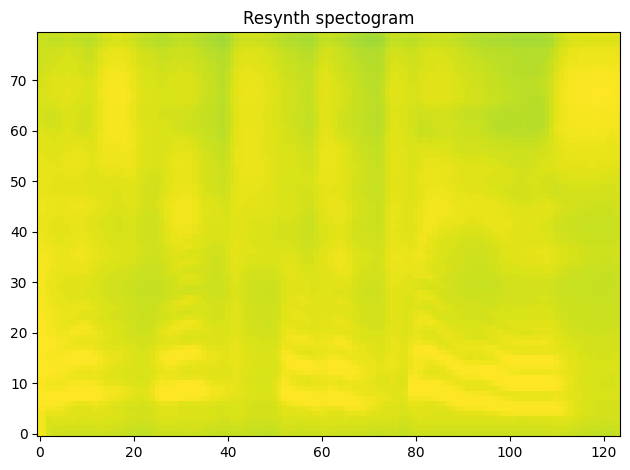

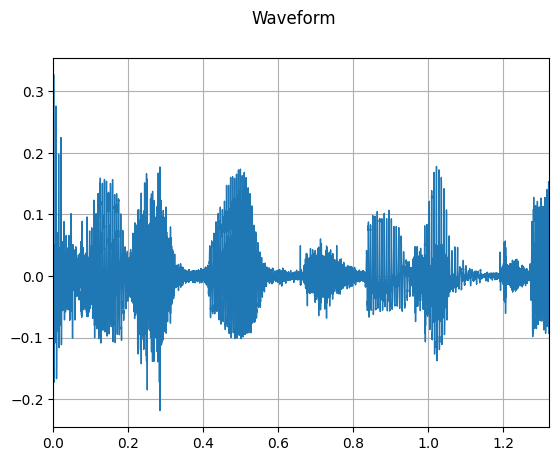

In [7]:
# Generate

codes = "304♩♩178♩♩635♩♩420♩♩628♩♩31♩♩249♩♩33♩♩348♩♩183♩♩434♩♩24♩♩31♩♩208♩♩565♩♩480♩♩105♩♩83♩♩30♩♩165♩♩61♩♩110♩♩312♩♩394♩♩1♩♩308♩♩308♩♩481♩♩517♩♩261♩♩517♩"
codes = codes.replace(' ', '').replace('♩♩', ' ').replace('♩', '')
print(codes)
codes = [int(x) for x in codes.split()]
codes_spec, _ = dvae.decode(torch.LongTensor(codes,).unsqueeze(0).to(device))
codes_spec = codes_spec * config.dvae.log_mel_multiplier
resynth = generator(codes_spec).detach().cpu().squeeze(0)
codes_spec = codes_spec.detach().cpu().squeeze(0)
print(len(codes), resynth.shape[1] / config.audio.sample_rate)

# Source
plot_specgram(codes_spec.cpu(), title="Resynth spectogram")
plot_waveform(resynth,xlim=(0,resynth.shape[1] / config.audio.sample_rate))
display(Audio(data=resynth, rate=config.audio.sample_rate))